In [3]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark


In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [6]:
file_path = "BostonHousing.csv"

housing_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(file_path)

housing_df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [8]:
from pyspark.ml.feature import VectorAssembler

features = [column for column in housing_df.columns if column != 'medv']

assembler = VectorAssembler(inputCols=features, outputCol="features_vector")

housing_df = assembler.transform(housing_df)

housing_df.select("features_vector", "medv").show(5)

+--------------------+----+
|     features_vector|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
+--------------------+----+
only showing top 5 rows



In [9]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features")

scaler_model = scaler.fit(housing_df)

housing_df = scaler_model.transform(housing_df)

housing_df.select("scaled_features", "medv").show(5)

+--------------------+----+
|     scaled_features|medv|
+--------------------+----+
|[7.34751712931429...|24.0|
|[0.00317501096205...|21.6|
|[0.00317268579840...|34.7|
|[0.00376327736512...|33.4|
|[0.00802762749650...|36.2|
+--------------------+----+
only showing top 5 rows



In [10]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")

pca_model = pca.fit(housing_df)

housing_df = pca_model.transform(housing_df)

housing_df.select("pca_features", "medv").show(5)

+--------------------+----+
|        pca_features|medv|
+--------------------+----+
|[-1.2551263234672...|24.0|
|[-1.8955383642584...|21.6|
|[-1.2788028017576...|34.7|
|[-0.7424275948415...|33.4|
|[-0.8955945817747...|36.2|
+--------------------+----+
only showing top 5 rows



In [11]:
import numpy as np
import pandas as pd

pca_values = np.array(housing_df.select("pca_features").rdd.flatMap(lambda x: x).collect())
medv_values = np.array(housing_df.select("medv").rdd.flatMap(lambda x: x).collect())

pandas_df = pd.DataFrame(pca_values, columns=["PC1", "PC2"])
pandas_df["medv"] = medv_values

print(pandas_df.head())

        PC1       PC2  medv
0 -1.255126  0.619209  24.0
1 -1.895538  0.438260  21.6
2 -1.278803  0.445907  34.7
3 -0.742428 -0.160003  33.4
4 -0.895595 -0.055524  36.2


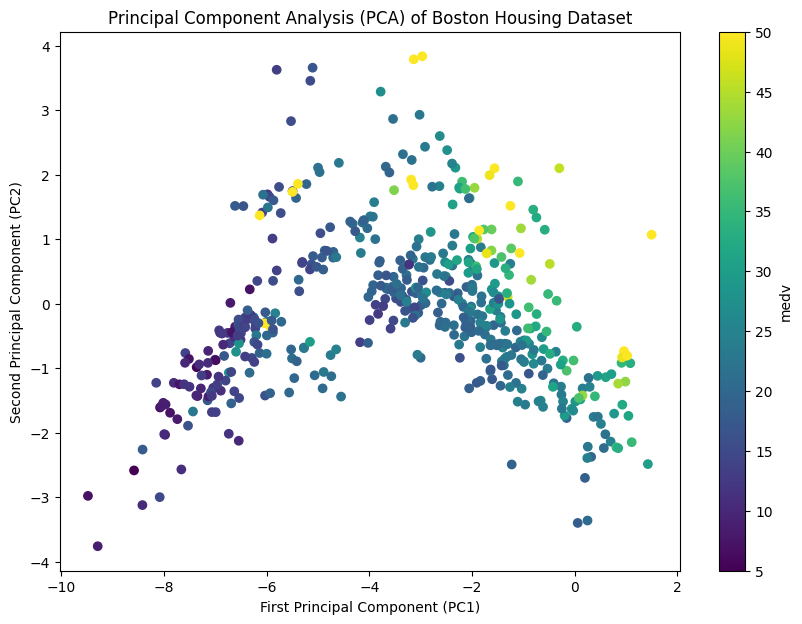

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(pandas_df["PC1"], pandas_df["PC2"], c=pandas_df["medv"], cmap='viridis')
plt.colorbar(label='medv')
plt.xlabel('First Principal Component (PC1)')
plt.ylabel('Second Principal Component (PC2)')
plt.title('Principal Component Analysis (PCA) of Boston Housing Dataset')
plt.show()

In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

(training_set, test_set) = housing_df.randomSplit([0.7, 0.3])

print("Training Dataset Count: " + str(training_set.count()))
print("Test Dataset Count: " + str(test_set.count()))

Training Dataset Count: 340
Test Dataset Count: 166


In [14]:
from pyspark.ml.regression import LinearRegression

linear_regression = LinearRegression(featuresCol='pca_features', labelCol='medv')

lr_model = linear_regression.fit(training_set)

print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [2.263272029096151,2.1575975066425634]
Intercept: 30.611128830131122


In [15]:
test_evaluation = lr_model.evaluate(test_set)

print("Root Mean Squared Error (RMSE) on test data: %f" % test_evaluation.rootMeanSquaredError)

print("R Squared (R2) on test data: %f" % test_evaluation.r2)


Root Mean Squared Error (RMSE) on test data: 6.560106
R Squared (R2) on test data: 0.440547


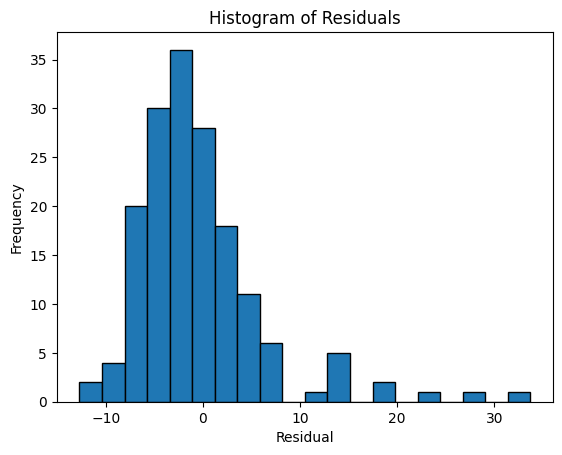

In [16]:
import matplotlib.pyplot as plt

residuals = test_evaluation.residuals

residuals_df = residuals.toPandas()

plt.hist(residuals_df['residuals'], bins=20, edgecolor='black')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [17]:
from pyspark.sql.functions import corr

predictions = test_evaluation.predictions
predicted_vs_actual = predictions.select("prediction", "medv")

correlation_value = predicted_vs_actual.stat.corr("prediction", "medv")

print("Correlation between predicted and actual values: ", correlation_value)


Correlation between predicted and actual values:  0.6664061642449609


In [18]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

linear_regression = LinearRegression(featuresCol='pca_features', labelCol='medv')

param_grid = ParamGridBuilder() \
    .addGrid(linear_regression.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(linear_regression.elasticNetParam, [0.0, 1.0]) \
    .build()

cross_validator = CrossValidator(estimator=linear_regression,
                                 estimatorParamMaps=param_grid,
                                 evaluator=RegressionEvaluator(labelCol="medv"),
                                 numFolds=5)

cv_model = cross_validator.fit(training_set)

print("Coefficients: " + str(cv_model.bestModel.coefficients))
print("Intercept: " + str(cv_model.bestModel.intercept))

cv_predictions = cv_model.transform(test_set)

Coefficients: [2.240082163508845,2.1391319920559884]
Intercept: 30.52915609111821
